In [1]:
import os
import sys

import warnings

sys.path.append(os.pardir)

# ignore warnings for AllenNLP Tango
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

- Load `CharacterImageProcessor`

In [2]:
from ceclcnn.modules.character_image_processor import CharacterImageProcessor

character_image_processor = CharacterImageProcessor(
    font_name="../dataset/fonts/NotoSansCJKjp-Regular.otf", 
    font_size=128 # default: 32; for better resolution
)

- Load `RandomErasing`

In [3]:
from ceclcnn.modules.random_erasing import RandomErasing

random_erasing = RandomErasing(
    p=0.6, # default:0.3
    max_area_ratio=0.4, 
    min_area_ratio=0.02, 
    max_aspect_ratio=2.0, 
    min_aspect_ratio=0.3
)

- Plot the result of applying random erasing to character image
  - Example: `吾輩は猫である。名前はまだない` in Japanese

Tokenized example (#num chars = 16): ['吾', '輩', 'は', '猫', 'で', 'あ', 'る', '。', '名', '前', 'は', 'ま', 'だ', '無', 'い', '。']
The shape of character images: (16, 128, 128)



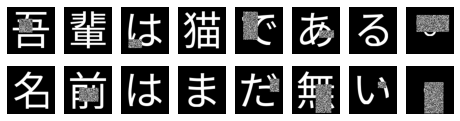

In [4]:
text_example = "吾輩は猫である。名前はまだ無い。"

#
# Convert text to character images
#

tokenized_example = list(text_example)
print(f'Tokenized example (#num chars = {len(tokenized_example)}): {tokenized_example}')

char_image_example = character_image_processor(tokenized_example)
print(f'The shape of character images: {char_image_example.shape}')

char_image_example = random_erasing.apply_augmentations(xs=char_image_example)
print()

#
# Plot the result
#

fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(8 ,2))

for i in range(len(char_image_example)):
    char_image = char_image_example[i]
    img = Image.fromarray(np.uint8(char_image * 255))
    
    axes[i // 8][i % 8].imshow(img, cmap='gray', vmin = 0, vmax = 255)
    axes[i // 8][i % 8].axis('off')

- Create GIF file from image sequence

In [5]:
os.makedirs('animation', exist_ok=True)

plot_imgs = []
for i in range(30):
    char_image_example = character_image_processor(tokenized_example)
    char_image_example = random_erasing.apply_augmentations(xs=char_image_example)
    
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(8, 2))
    fig.patch.set_facecolor('white')

    for j in range(len(char_image_example)):
        char_image = char_image_example[j]
        img = Image.fromarray(np.uint8(char_image * 255))
        
        axes[j // 8][j % 8].imshow(img, cmap='gray', vmin = 0, vmax = 255)
        axes[j // 8][j % 8].axis('off')
    
    fig.savefig(f'animation/{i}.png', bbox_inces='tight')
    plt.close()

!ffmpeg -hide_banner -loglevel error -i animation/%d.png -vf palettegen -y palette.png
!ffmpeg -hide_banner -loglevel error -f image2 -r 1 -i animation/%d.png -i animation/palette.png -filter_complex paletteuse -y anim_re.gif 